Imports

In [1]:
import csv
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

CUDA Loaders

In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()

def to_device(entity, device):
    """Move tensor(s) to chosen device"""
    if isinstance(entity, (list,tuple)):
        return [to_device(x, device) for x in entity]
    return entity.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, loader, device):
        self.loader = loader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for entity in self.loader:
            yield to_device(entity, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.loader)

Model Architecture and Training

In [3]:
import numpy as np
from itertools import chain
from model import CNN
from torchvision.models import resnet50, ResNet50_Weights

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from utils import EarlyStopping

from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def co_teaching_loss(model1_loss, model2_loss, rt):
    _, model1_sm_idx = torch.topk(model1_loss, k=int(int(model1_loss.size(0)) * rt), largest=False)
    _, model2_sm_idx = torch.topk(model2_loss, k=int(int(model2_loss.size(0)) * rt), largest=False)

    # Co-teaching
    model1_loss_filter = torch.zeros((model1_loss.size(0))).cuda()
    model1_loss_filter[model2_sm_idx] = 1.0
    model1_loss = (model1_loss_filter * model1_loss).sum()

    model2_loss_filter = torch.zeros((model2_loss.size(0))).cuda()
    model2_loss_filter[model1_sm_idx] = 1.0
    model2_loss = (model2_loss_filter * model2_loss).sum()

    return model1_loss, model2_loss


def train_step(data_loader, gpu: bool, model_list: list, optimizer, criterion, rt, warmups):
    global_step = 0
    avg_accuracy = 0.
    avg_loss = 0.

    model1, model2 = model_list
    model1 = model1.train()
    model2 = model2.train()
    for x, y in data_loader:
        # Forward and Backward propagation
        x, y = x.to(device), y.to(device)

        out1 = model1(x)
        out2 = model2(x)

        out2_pred = torch.argmax(out2, 1)
        out1_pred = torch.argmax(out1, 1)

        model1_loss = criterion(out1, y)
        model2_loss = criterion(out2, y)
        model1_loss, model2_loss = co_teaching_loss(model1_loss=model1_loss, model2_loss=model2_loss, rt=rt)

        # loss exchange
        optimizer.zero_grad()
        model1_loss.backward()
        torch.nn.utils.clip_grad_norm_(model1.parameters(), 5.0)
        optimizer.step()

        optimizer.zero_grad()
        model2_loss.backward()
        torch.nn.utils.clip_grad_norm_(model2.parameters(), 5.0)
        optimizer.step()

        avg_loss += (model1_loss.item() + model2_loss.item())

        # Compute accuracy
        acc = torch.eq(torch.argmax(out1, 1), y).float()
        avg_accuracy += acc.mean()
        global_step += 1

    return avg_accuracy / global_step, avg_loss / global_step, [model1, model2]


def test_step(data_loader, gpu: bool, model):
    model = model.eval()
    global_step = 0
    avg_accuracy = 0.
    predicted_labels = []

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, preds = torch.max(logits, 1)
        acc = torch.eq(torch.argmax(logits, 1), y)
        acc = acc.cpu().numpy()
        acc = np.mean(acc)
        avg_accuracy += acc
        global_step += 1
        predicted_labels.extend(preds.cpu().numpy())

    return avg_accuracy / global_step, predicted_labels


def valid_step(data_loader, gpu: bool, model):
    model = model.eval()
    global_step = 0
    avg_accuracy = 0.

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        acc = torch.eq(torch.argmax(logits, 1), y)
        acc = acc.cpu().numpy()
        acc = np.mean(acc)
        avg_accuracy += acc
        global_step += 1
    return avg_accuracy / global_step


def update_reduce_step(cur_step1, num_gradual, tau):
    return 1.0 - tau * min(cur_step1 / num_gradual, 1)


def train(lr, tau, num_gradual, warmups, gpu = True, epochs = 10):
    model1 = resnet50(ResNet50_Weights.IMAGENET1K_V2)
    model2 = resnet50(ResNet50_Weights.IMAGENET1K_V2)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using" + str(device) + "for training")

    model1.to(device)
    model2.to(device)

    # learning history
    train_acc_list = []
    test_acc_list = []

    criterion = nn.CrossEntropyLoss(reduce=False)
    optimizer = optim.Adam(chain(model1.parameters(), model2.parameters()), lr, weight_decay=1e-3)
    for e in range(epochs):
        # update reduce step
        curstep1 = e
        rt = update_reduce_step(curstep1, num_gradual, tau)

        # training step
        train_accuracy, avg_loss, model_list = train_step(data_loader=trainLoader,
                                                          gpu=gpu,
                                                          model_list=[model1, model2],
                                                          optimizer=optimizer,
                                                          criterion=criterion,
                                                          rt=rt,
                                                          warmups=warmups)
        model1, model2 = model_list

        if warmups > 0:
            warmups = warmups - 1

        # testing/valid step
        test_accuracy, predicted_labels = test_step(data_loader=testLoader,
                                  gpu=gpu,
                                  model=model1)

        dev_accuracy = valid_step(data_loader=valLoader,
                                  gpu=gpu,
                                  model=model1)

        train_accuracy = train_accuracy.cpu().data.numpy()
        train_acc_list.append(train_accuracy)
        test_acc_list.append(test_accuracy)

        print('Epoch: {:04d}'.format(e + 1), '| Train Acc: {:.4f}'.format(train_accuracy), '| Test Acc: {:.4f}'.format(test_accuracy), '| Dev Acc: {:.4f}'.format(dev_accuracy), '| Loss: {:.4f}'.format(avg_loss), '| Reduce rate: {:.4f}'.format(rt), '| rt : {:.4f}'.format(rt))

        # logging.info(
        #     '{} epoch, Train Loss {}, Train accuracy {}, Dev accuracy {}, Test accuracy {}, Reduce rate {}'.format(e + 1,
        #                                                                                                         avg_loss,
        #                                                                                                         train_accuracy,
        #                                                                                                         dev_accuracy,
        #                                                                                                         test_accuracy,
        #                                                                                                         rt))

        # early_stopping(-dev_accuracy, model1, test_acc=test_accuracy)
        # if early_stopping.early_stop:
        #     logging.info('Training stopped! Best accuracy = {}'.format(max(early_stopping.acc_list)))
        #     break

    # learning curve plot
    return train_acc_list, test_acc_list, epochs, predicted_labels

Run and Evaluation

In [4]:
import datasets
from torchvision.transforms import ToTensor as toTensor
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt

tf = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
    # Using previous information, skipping manual calculation
])

tf_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
    # Using previous information, skipping manual calculation
])

trainDataset = datasets.C100Dataset('dataset/data/cifar100_nl.csv', 
                                    root_dir="dataset",
                                    train=True,
                                    transform= tf,
                                    target_transform=torch.tensor)

testDataset = datasets.C100Dataset('dataset/data/cifar100_nl_test.csv',
                                    root_dir="dataset",
                                    test=True,
                                    transform = tf_test,
                                    target_transform=torch.tensor)
print(trainDataset[0][0].type() )
trainDataset, valDataset = random_split(trainDataset, [.8, .2])

print( trainDataset[0][1].type() )

torch.FloatTensor
torch.LongTensor


In [5]:
# Set parameters
lr = 0.001
tau = 0.5
warmups = 50
num_gradual = 10
gpu = True
epochs = 100
batch_size = 700

# Load loaders

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainLoader = DataLoader(trainDataset, pin_memory=True, batch_size=batch_size, shuffle=True)
valLoader = DataLoader(valDataset, pin_memory=True, batch_size=batch_size, shuffle=False)
testLoader = DataLoader(testDataset, pin_memory=True, batch_size=batch_size, shuffle=False)

trainLoader = DeviceDataLoader(trainLoader, device)
valLoader = DeviceDataLoader(valLoader, device)
testLoader = DeviceDataLoader(testLoader, device)

# Training run

train_acc_list, test_acc_list, epochs, predicted_labels = train(lr=lr, tau=tau, num_gradual=num_gradual, warmups=warmups, gpu=gpu, epochs=epochs)

print(train_acc_list)


xrange = [(i + 1) for i in range(epochs)]
plt.plot(xrange, train_acc_list, 'b', label='Training accuracy')
plt.plot(xrange, test_acc_list, 'r', label='Test accuracy')
plt.legend()
plt.title('Coteaching ')
plt.savefig('l_curve.png')

c:\Users\aaron\miniconda3\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Usingcuda:0for training


c:\Users\aaron\miniconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: 0001 | Train Acc: 0.0550 | Test Acc: 0.1000 | Dev Acc: 0.0678 | Loss: 8239.0510 | Reduce rate: 1.0000 | rt : 1.0000
Epoch: 0002 | Train Acc: 0.2185 | Test Acc: 0.2297 | Dev Acc: 0.1667 | Loss: 4677.7021 | Reduce rate: 0.9500 | rt : 0.9500
Epoch: 0003 | Train Acc: 0.3010 | Test Acc: 0.3038 | Dev Acc: 0.2264 | Loss: 3618.5241 | Reduce rate: 0.9000 | rt : 0.9000
Epoch: 0004 | Train Acc: 0.3475 | Test Acc: 0.0794 | Dev Acc: 0.0484 | Loss: 2867.0056 | Reduce rate: 0.8500 | rt : 0.8500
Epoch: 0005 | Train Acc: 0.3672 | Test Acc: 0.3051 | Dev Acc: 0.2367 | Loss: 2377.9645 | Reduce rate: 0.8000 | rt : 0.8000
Epoch: 0006 | Train Acc: 0.3745 | Test Acc: 0.1325 | Dev Acc: 0.1001 | Loss: 1982.4492 | Reduce rate: 0.7500 | rt : 0.7500
Epoch: 0007 | Train Acc: 0.3767 | Test Acc: 0.2895 | Dev Acc: 0.2162 | Loss: 1678.2508 | Reduce rate: 0.7000 | rt : 0.7000
Epoch: 0008 | Train Acc: 0.3793 | Test Acc: 0.3089 | Dev Acc: 0.2338 | Loss: 1411.2987 | Reduce rate: 0.6500 | rt : 0.6500


KeyboardInterrupt: 

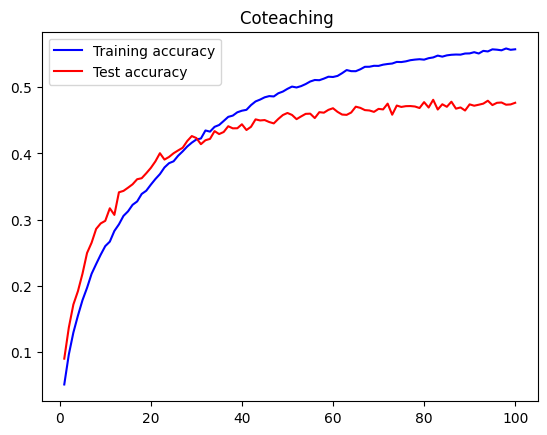

In [ ]:
xrange = [(i + 1) for i in range(epochs)]
plt.plot(xrange, train_acc_list, 'b', label='Training accuracy')
plt.plot(xrange, test_acc_list, 'r', label='Test accuracy')
plt.legend()
plt.title('Coteaching ')
plt.savefig('l_curve.png')